# Analyze labeled-datasets

In [2]:
import os
import pandas as pd
from pathlib import Path
import sys

# Add the parent directory to the path to access modules two levels up
sys.path.append(os.path.abspath('../..'))


# Base directory to search
base_dir = '/Users/jgilhuly/Documents/dev/GitHub/dataset-generation-research/labeled_datasets'

def combine_csvs(paths):
    dfs = []
    for path in paths:
        try:
            df = pd.read_csv(path)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {path}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Find all CSV files recursively, excluding the 'old' directory
all_csvs = []
if os.path.exists(base_dir):
    for path in Path(base_dir).rglob('*.csv'):
        # Skip files in the 'old' directory
        if 'old' not in path.parts:
            all_csvs.append(path)
else:
    print(f"Directory not found: {base_dir}")

# Convert paths to strings
all_csv_paths = [str(p) for p in all_csvs]

# Create temp directory if it doesn't exist
os.makedirs('temp', exist_ok=True)

# 1. Combine all CSVs
all_combined = combine_csvs(all_csv_paths)
all_combined.to_csv('temp/all_datasets.csv', index=False)
print(f"Total rows in all combined datasets: {len(all_combined)}")

# 2. Synthetic only
synthetic = all_combined[all_combined['synthetic'] == True]
synthetic.to_csv('temp/synthetic_only.csv', index=False)
print(f"Total rows in synthetic datasets: {len(synthetic)}")

# 3. Non-synthetic only
non_synthetic = all_combined[all_combined['synthetic'] == False]
non_synthetic.to_csv('temp/non_synthetic_only.csv', index=False)
print(f"Total rows in non-synthetic datasets: {len(non_synthetic)}")

# 4. English only
english = all_combined[all_combined['language'] == 'en']
english.to_csv('temp/english_only.csv', index=False)
print(f"Total rows in English datasets: {len(english)}")

# 5. Synthetic + English
synthetic_english = all_combined[(all_combined['synthetic'] == True) & (all_combined['language'] == 'en')]
synthetic_english.to_csv('temp/synthetic_english.csv', index=False)
print(f"Total rows in synthetic English datasets: {len(synthetic_english)}")

# 6. Non-synthetic + English
non_synthetic_english = all_combined[(all_combined['synthetic'] == False) & (all_combined['language'] == 'en')]
non_synthetic_english.to_csv('temp/non_synthetic_english.csv', index=False)
print(f"Total rows in non-synthetic English datasets: {len(non_synthetic_english)}")

Total rows in all combined datasets: 74917
Total rows in synthetic datasets: 45100
Total rows in non-synthetic datasets: 29817
Total rows in English datasets: 52946
Total rows in synthetic English datasets: 30780
Total rows in non-synthetic English datasets: 22166


In [5]:
# Print row counts by label for English datasets
print("\nAnalyzing label distributions in English datasets...")

# For all English data
print("\nLabel distribution in all English data:")
english_label_counts = english['label'].value_counts()
print(english_label_counts)

# Calculate percentage for all English data
english_label_percentage = (english_label_counts / len(english) * 100).round(2)
print("\nPercentage of rows by label in all English data:")
for label, pct in english_label_percentage.items():
    print(f"{label}: {pct}%")

# For synthetic English data
print("\nLabel distribution in synthetic English data:")
synthetic_english_label_counts = synthetic_english['label'].value_counts()
print(synthetic_english_label_counts)

# Calculate percentage for synthetic English data
synthetic_english_percentage = (synthetic_english_label_counts / len(synthetic_english) * 100).round(2)
print("\nPercentage of rows by label in synthetic English data:")
for label, pct in synthetic_english_percentage.items():
    print(f"{label}: {pct}%")

# For non-synthetic English data
print("\nLabel distribution in non-synthetic English data:")
non_synthetic_english_label_counts = non_synthetic_english['label'].value_counts()
print(non_synthetic_english_label_counts)

# Calculate percentage for non-synthetic English data
non_synthetic_english_percentage = (non_synthetic_english_label_counts / len(non_synthetic_english) * 100).round(2)
print("\nPercentage of rows by label in non-synthetic English data:")
for label, pct in non_synthetic_english_percentage.items():
    print(f"{label}: {pct}%")


Analyzing label distributions in English datasets...

Label distribution in all English data:
label
factual         35260
hallucinated    17584
NOT_PARSABLE      102
Name: count, dtype: int64

Percentage of rows by label in all English data:
factual: 66.6%
hallucinated: 33.21%
NOT_PARSABLE: 0.19%

Label distribution in synthetic English data:
label
hallucinated    15600
factual         15079
NOT_PARSABLE      101
Name: count, dtype: int64

Percentage of rows by label in synthetic English data:
hallucinated: 50.68%
factual: 48.99%
NOT_PARSABLE: 0.33%

Label distribution in non-synthetic English data:
label
factual         20181
hallucinated     1984
NOT_PARSABLE        1
Name: count, dtype: int64

Percentage of rows by label in non-synthetic English data:
factual: 91.04%
hallucinated: 8.95%
NOT_PARSABLE: 0.0%



Rows by language:
language
en    52946
pt     9739
ja     8165
ko     1432
fr     1255
es     1240
zh      140
Name: count, dtype: int64


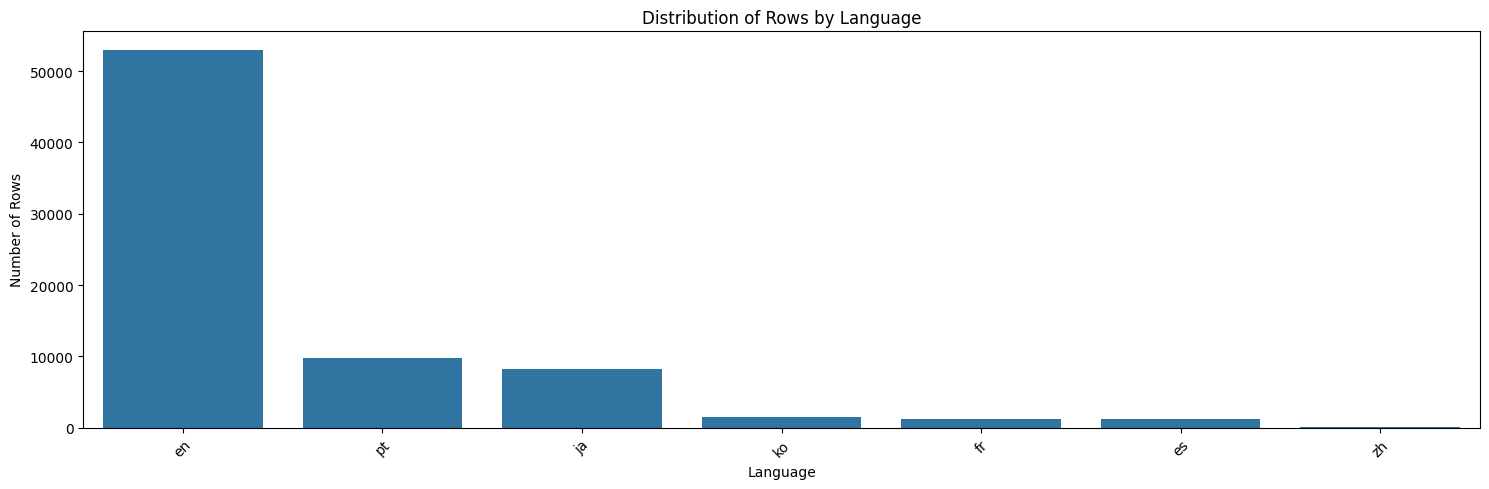


Percentage of rows by language:
en: 70.67%
pt: 13.0%
ja: 10.9%
ko: 1.91%
fr: 1.68%
es: 1.66%
zh: 0.19%


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count rows by language in all_combined
language_counts = all_combined['language'].value_counts()
print("\nRows by language:")
print(language_counts)

# Create a bar plot to visualize language distribution
plt.figure(figsize=(15, 5))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Distribution of Rows by Language')
plt.xlabel('Language')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate percentage of rows by language
language_percentage = (language_counts / len(all_combined) * 100).round(2)
print("\nPercentage of rows by language:")
for lang, pct in language_percentage.items():
    print(f"{lang}: {pct}%")


Calculating token counts for all datasets...

Token count statistics:
Total tokens across all rows: 13,899,271

Average tokens per row:
Input: 32.1
Output: 49.5
Reference: 103.9
Total: 185.5


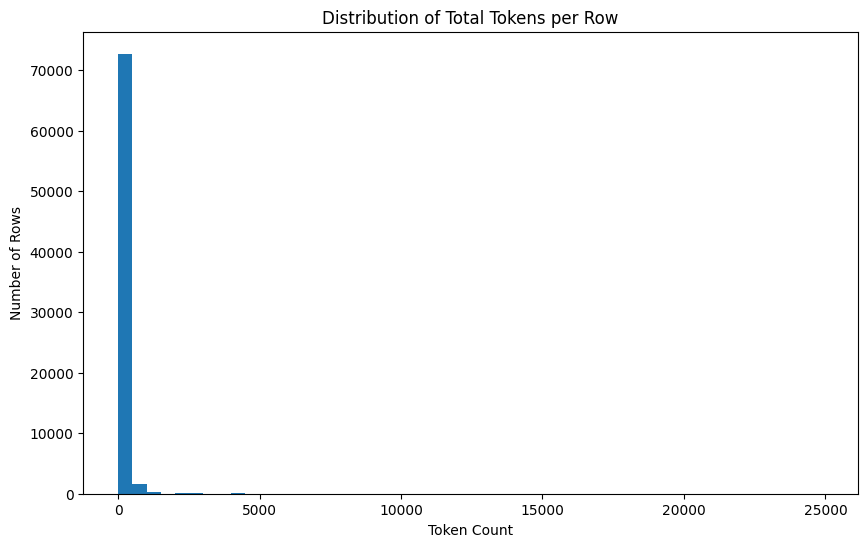

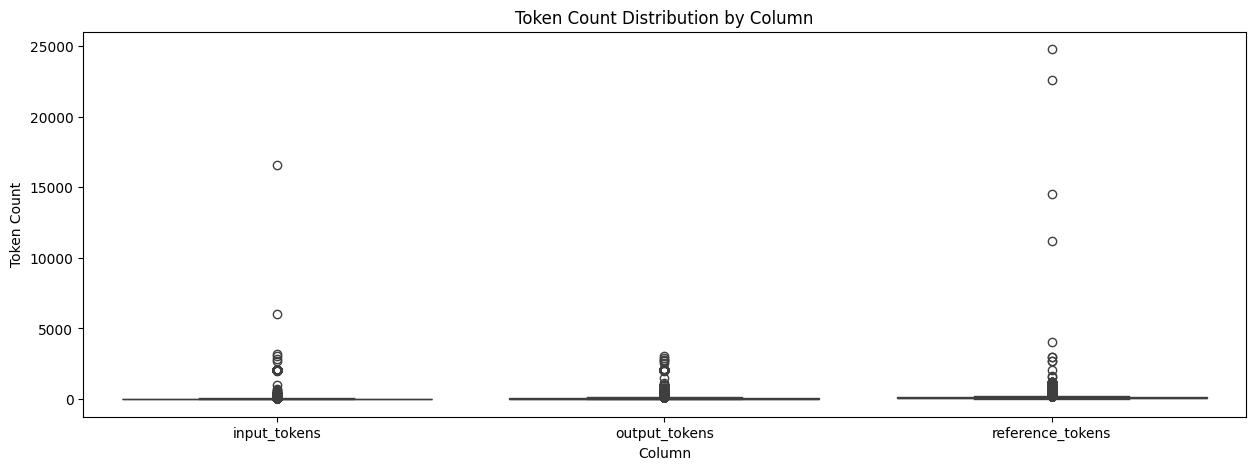

In [3]:
# Calculate token counts for combined input, output, and reference columns
import matplotlib.pyplot as plt
import tiktoken
import seaborn as sns


def count_tokens(text, encoding_name="cl100k_base"):
    """Count the number of tokens in a text string."""
    if pd.isna(text):
        return 0
    
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(str(text)))

print("Calculating token counts for all datasets...")

# Add token count columns to the dataframe
all_combined['input_tokens'] = all_combined['input'].apply(count_tokens)
all_combined['output_tokens'] = all_combined['output'].apply(count_tokens)
all_combined['reference_tokens'] = all_combined['reference'].apply(count_tokens)
all_combined['total_tokens'] = all_combined['input_tokens'] + all_combined['output_tokens'] + all_combined['reference_tokens']

# Display token count statistics
print("\nToken count statistics:")
print(f"Total tokens across all rows: {all_combined['total_tokens'].sum():,}")
print("\nAverage tokens per row:")
print(f"Input: {all_combined['input_tokens'].mean():.1f}")
print(f"Output: {all_combined['output_tokens'].mean():.1f}")
print(f"Reference: {all_combined['reference_tokens'].mean():.1f}")
print(f"Total: {all_combined['total_tokens'].mean():.1f}")

# Create histograms of token distributions
plt.figure(figsize=(10, 6))
plt.hist(all_combined['total_tokens'], bins=50)
plt.title('Distribution of Total Tokens per Row')
plt.xlabel('Token Count')
plt.ylabel('Number of Rows')
plt.show()

# Create a boxplot to compare token counts across different columns
token_data = pd.melt(
    all_combined[['input_tokens', 'output_tokens', 'reference_tokens']], 
    var_name='Column', 
    value_name='Token Count'
)

plt.figure(figsize=(15, 5))
sns.boxplot(x='Column', y='Token Count', data=token_data)
plt.title('Token Count Distribution by Column')
plt.show()


/var/folders/z6/6g1hmm4x2dl0z84s6bwkgdzr0000gn/T/ipykernel_37775/3664640697.py:26: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'temp/{dataset_file}')


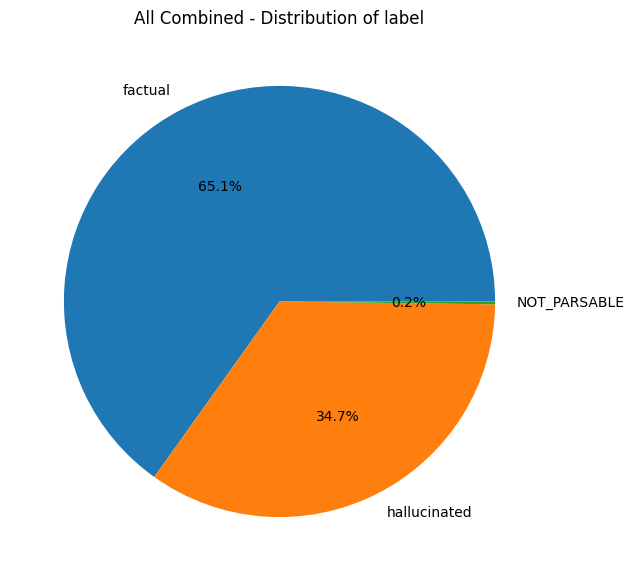

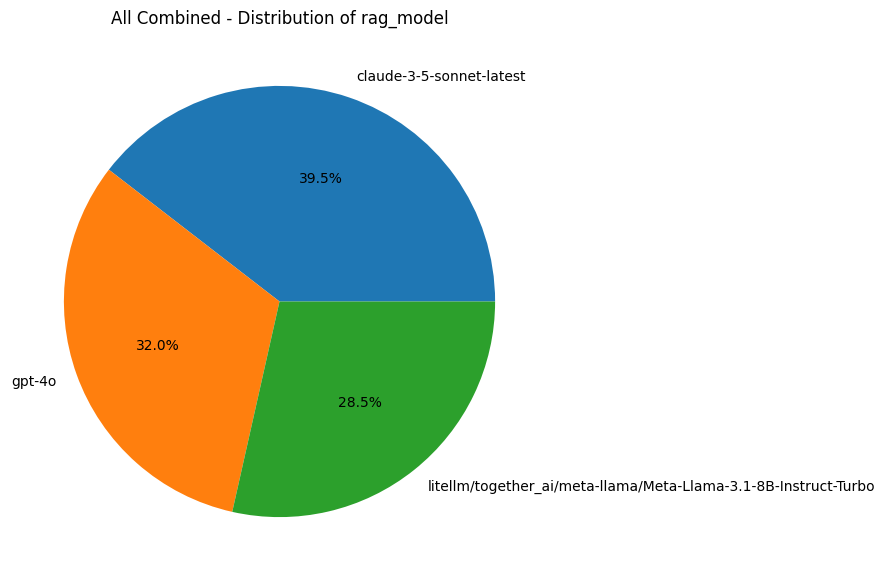

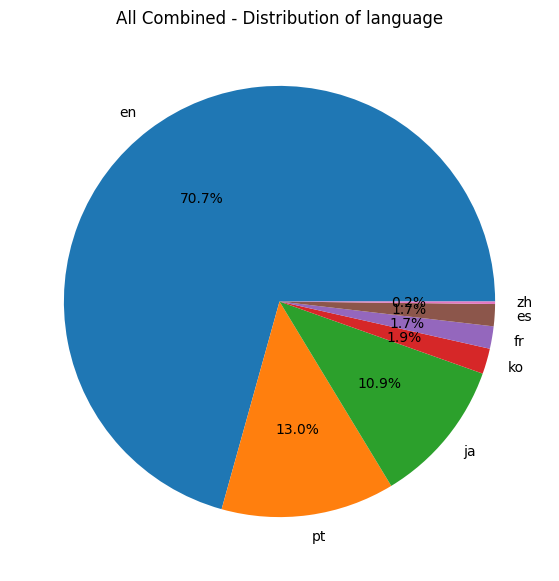

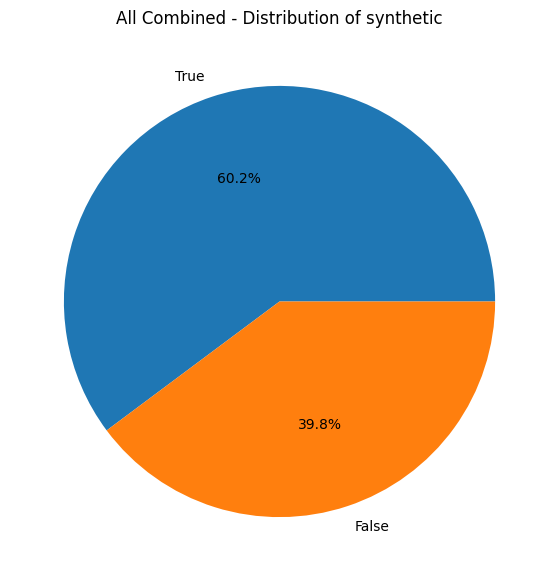

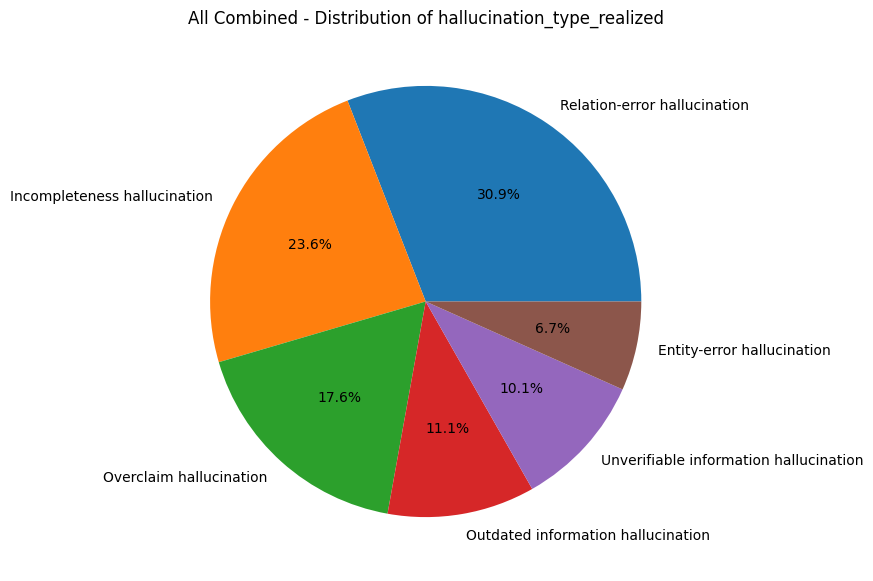

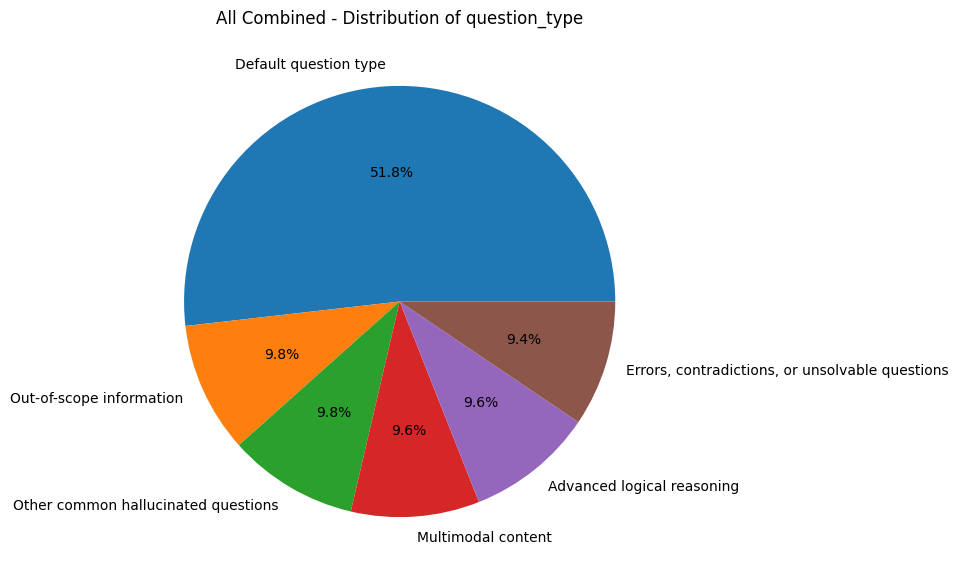

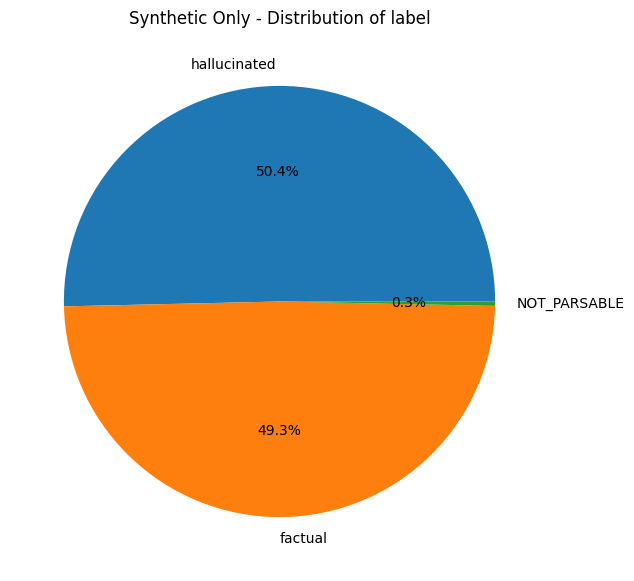

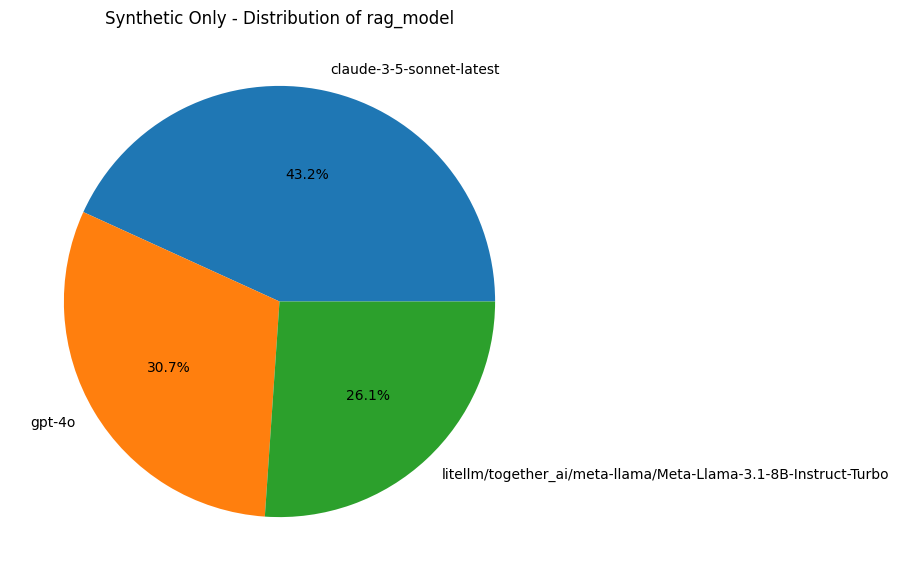

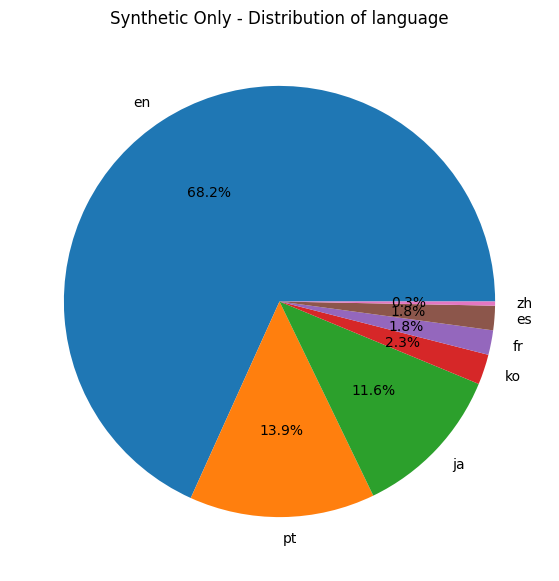

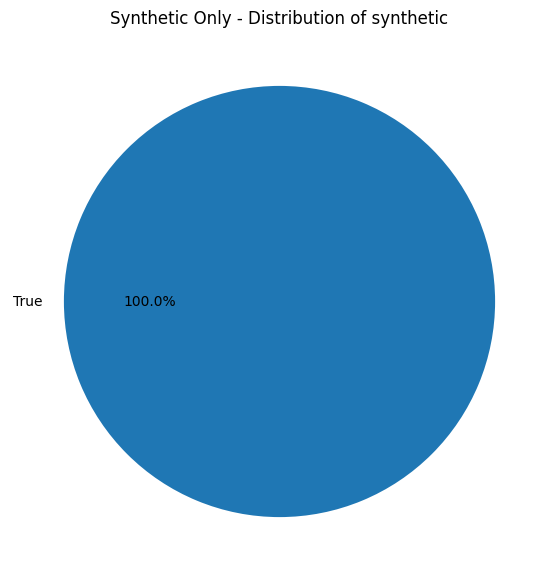

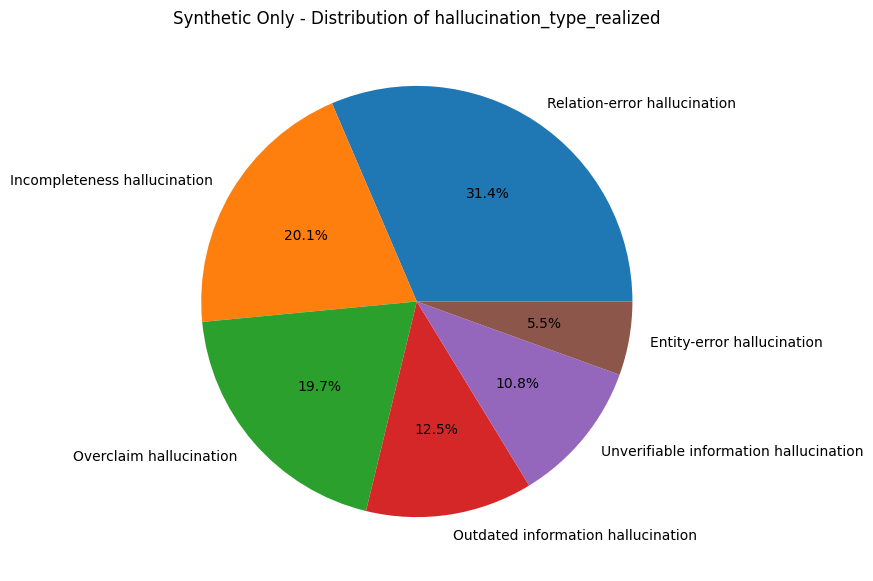

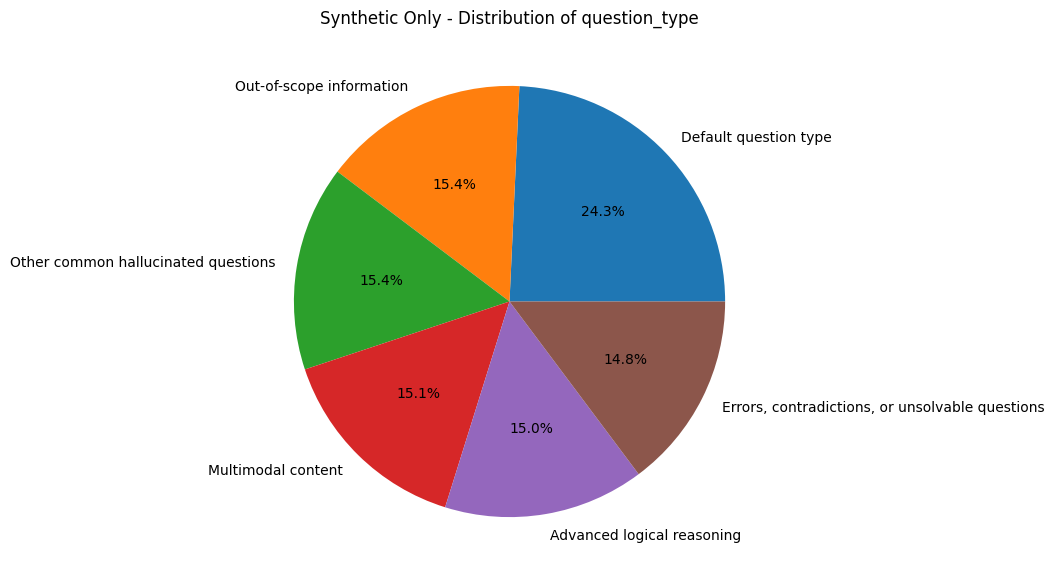

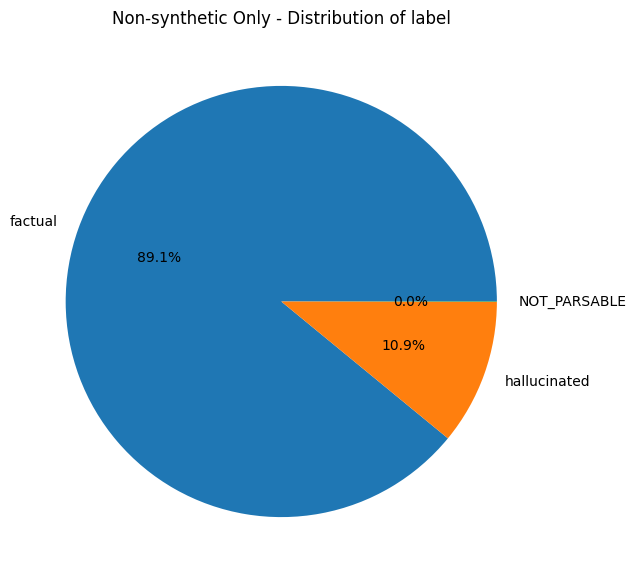

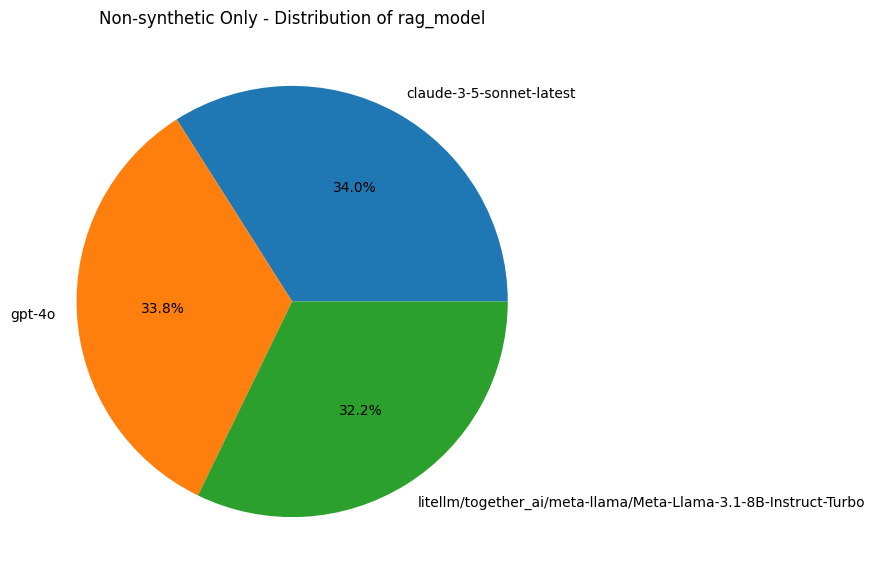

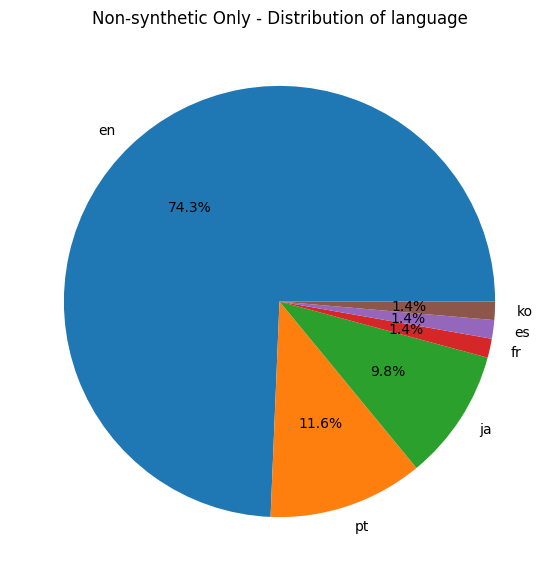

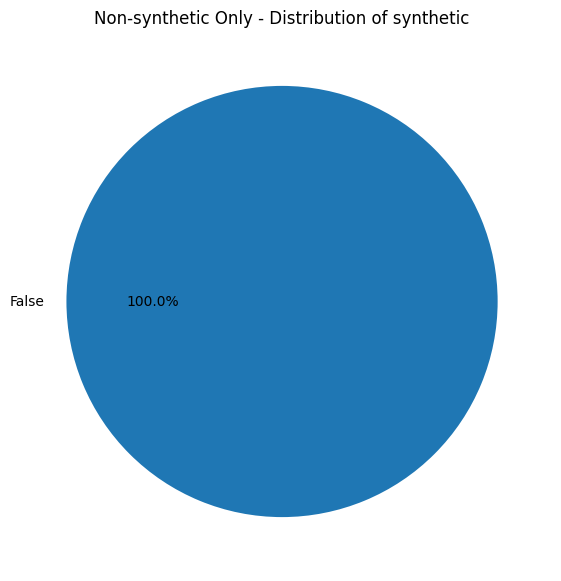

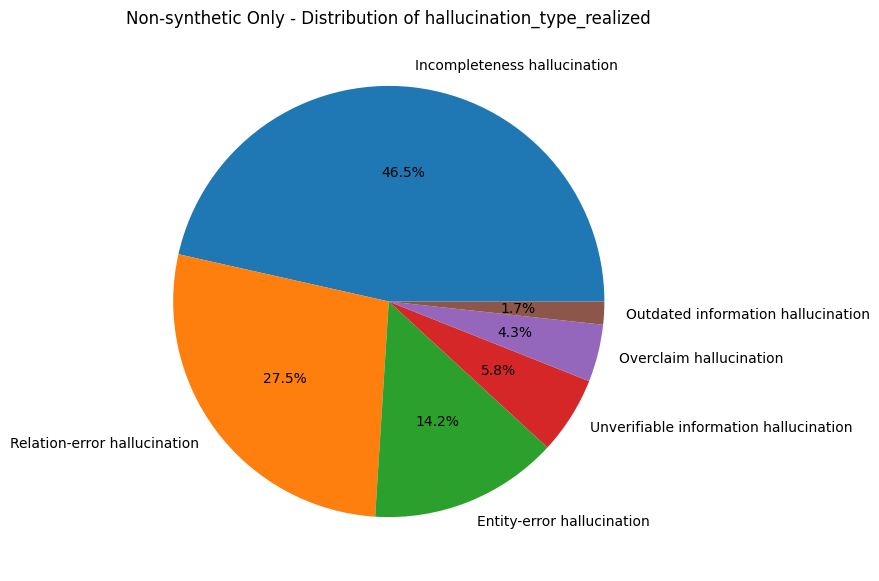

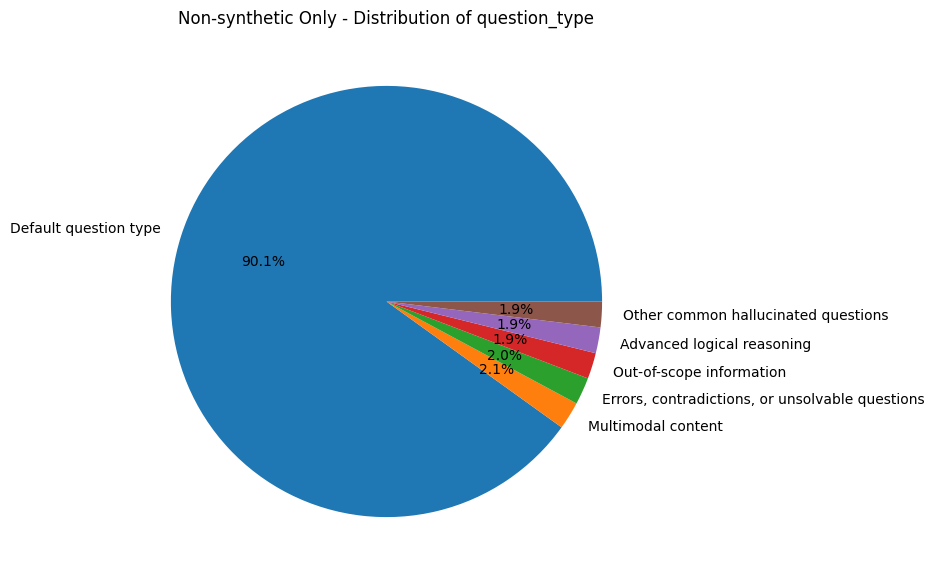

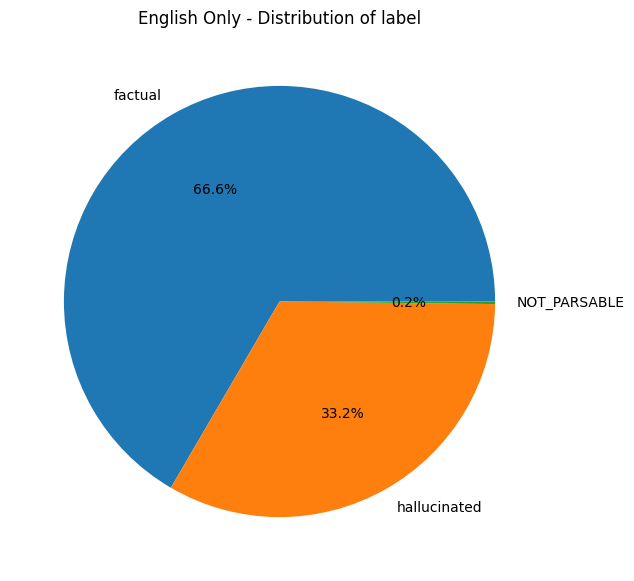

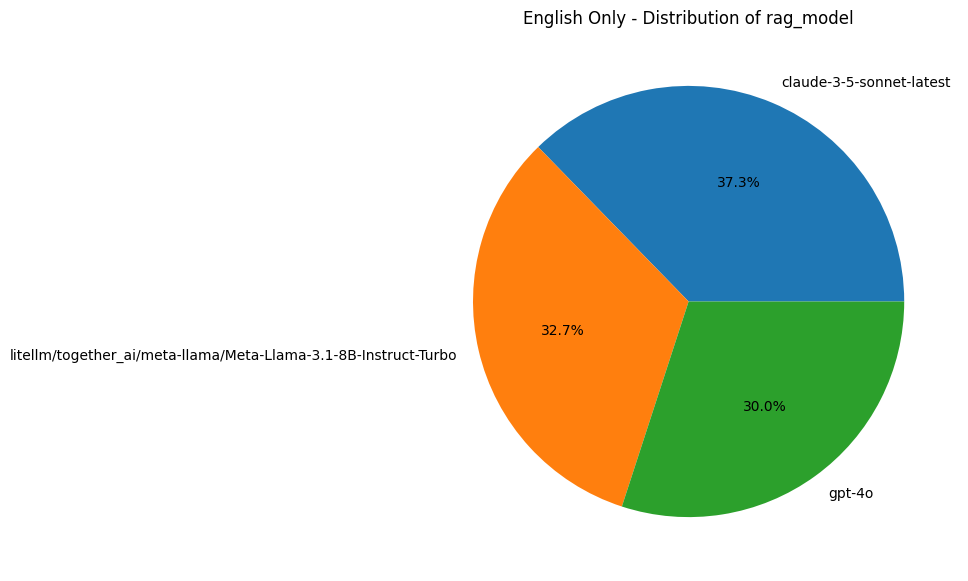

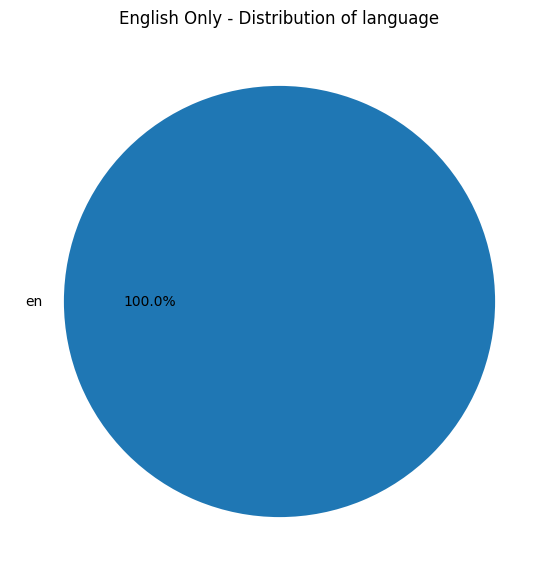

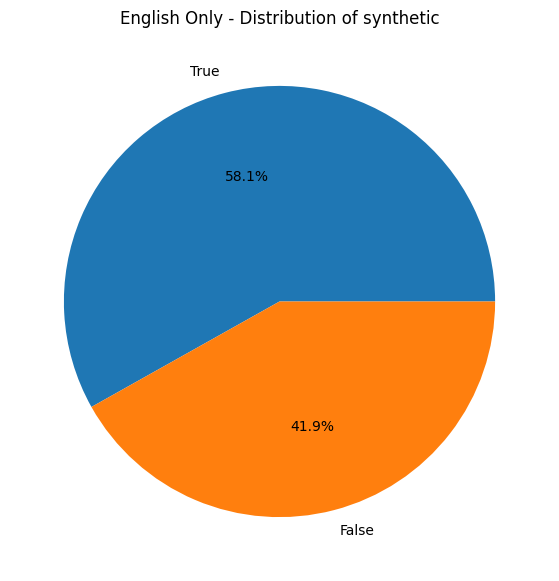

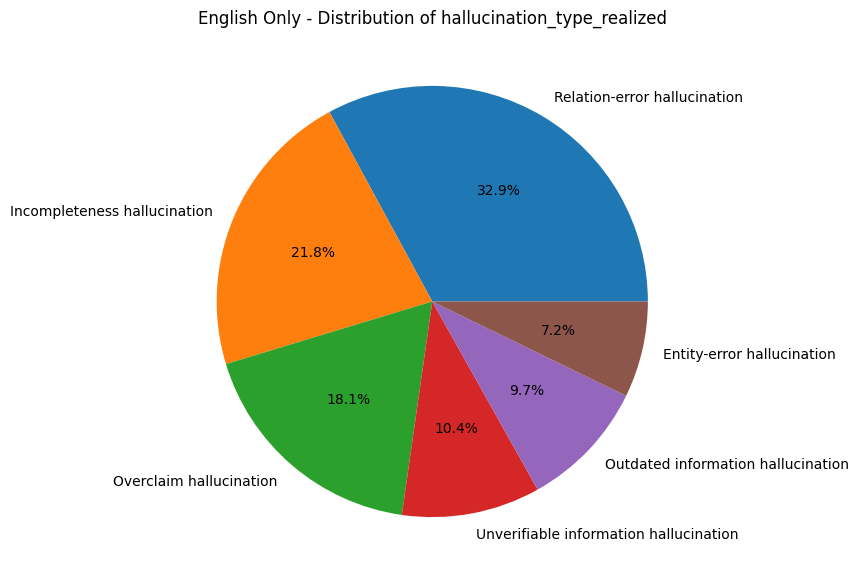

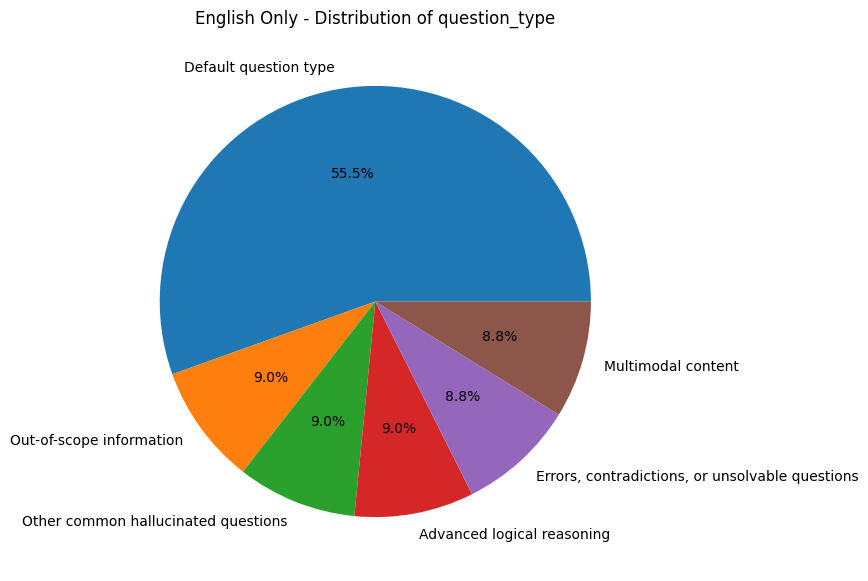

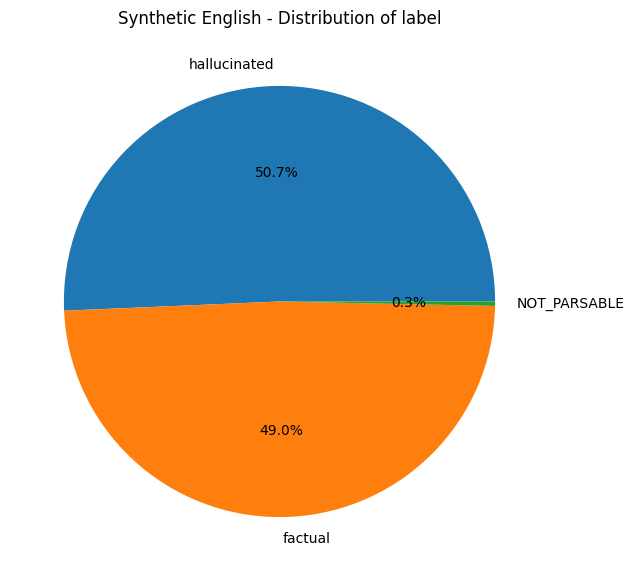

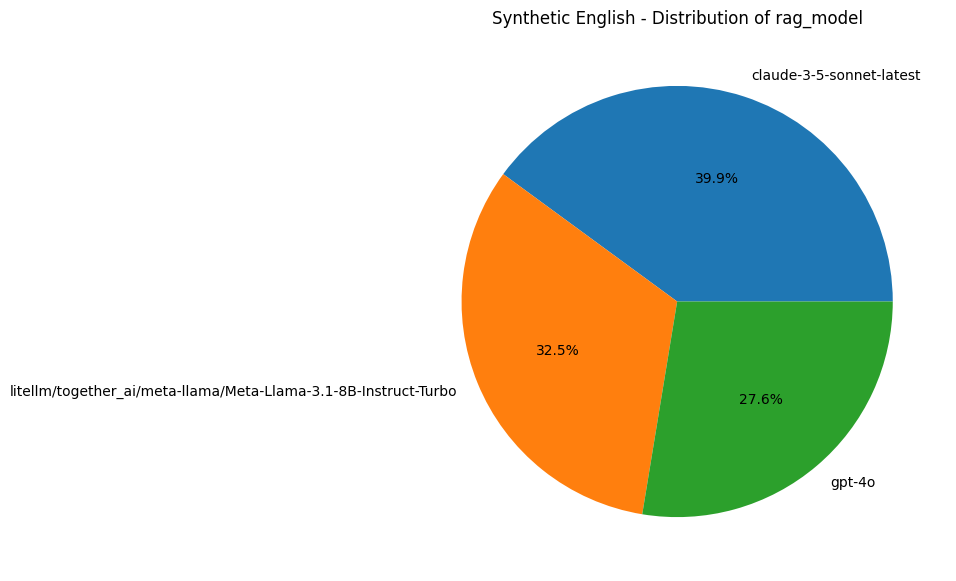

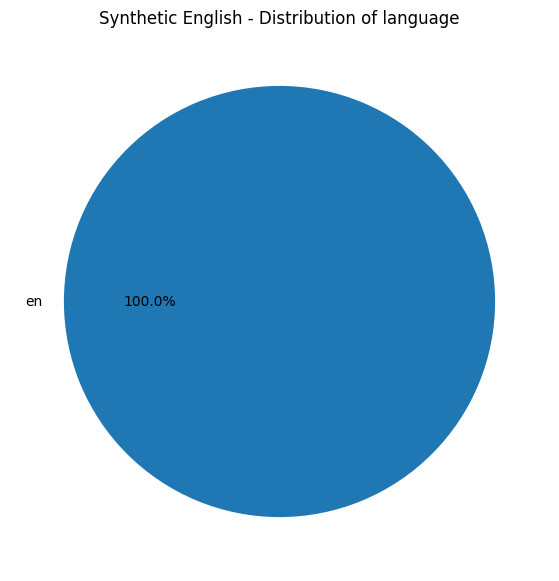

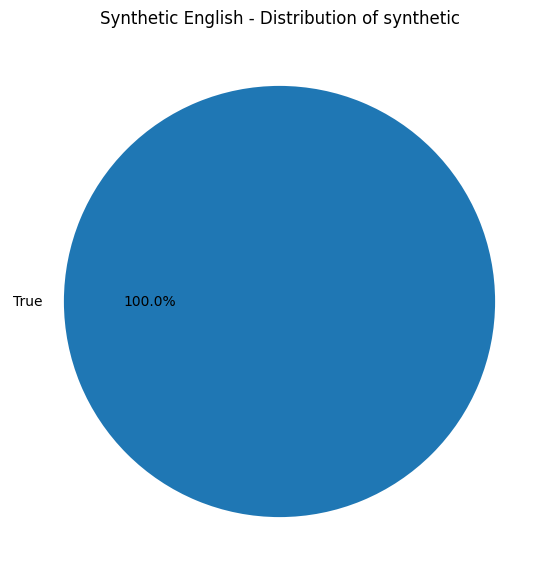

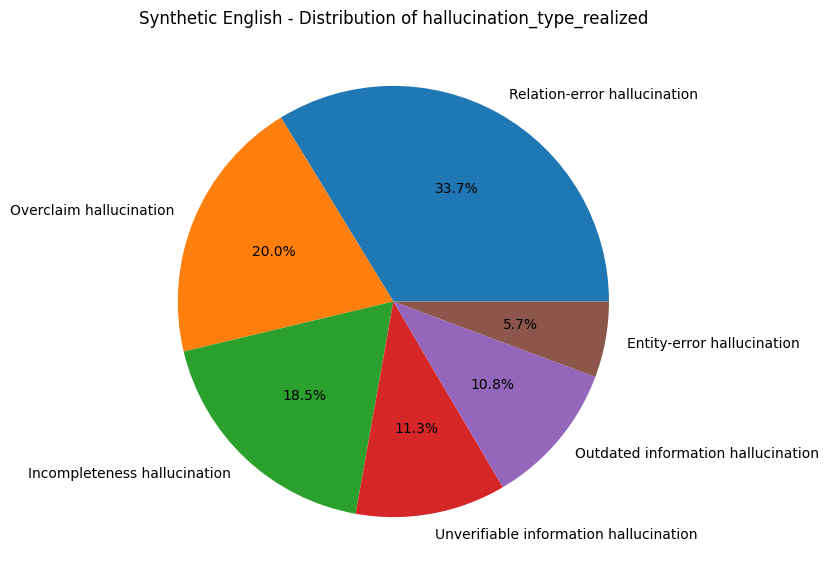

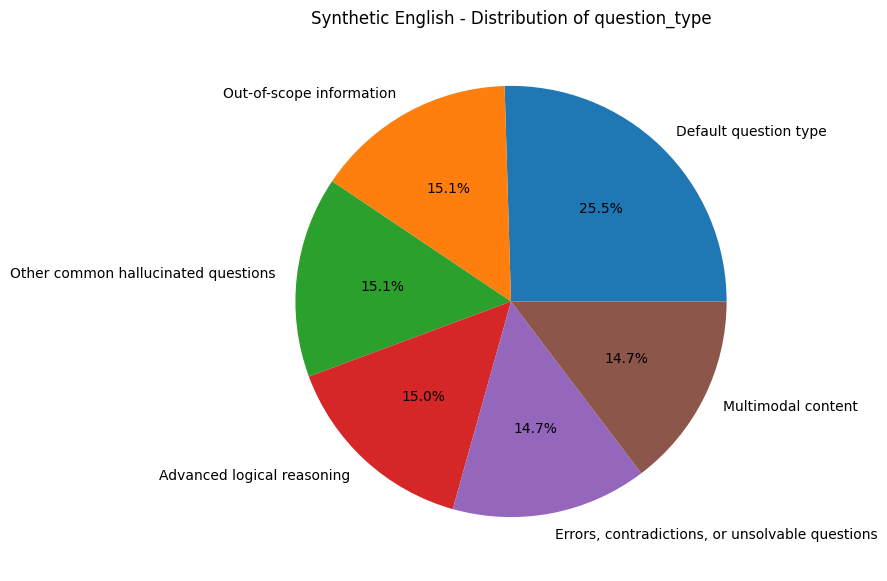

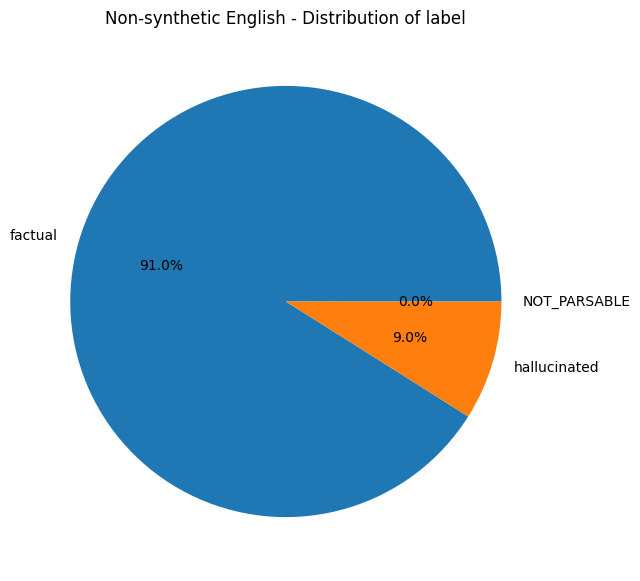

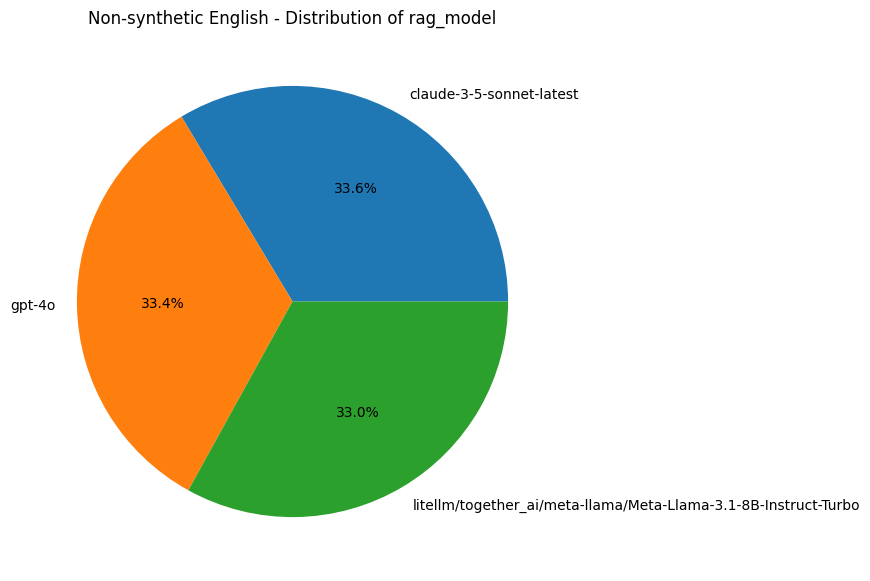

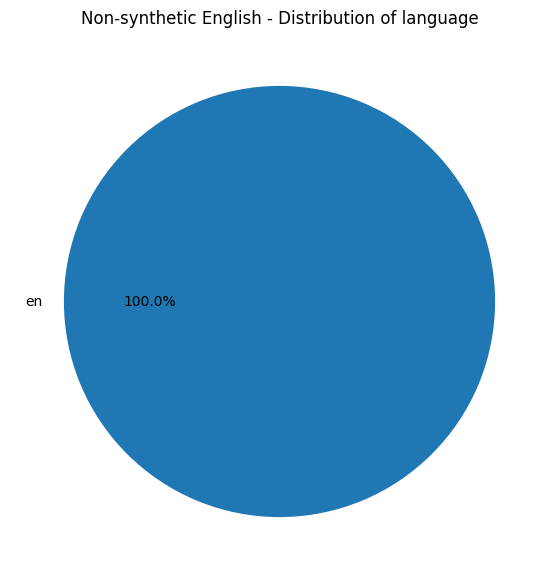

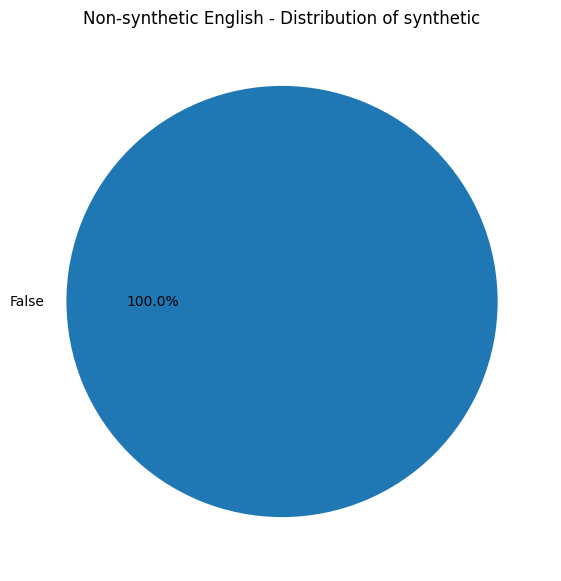

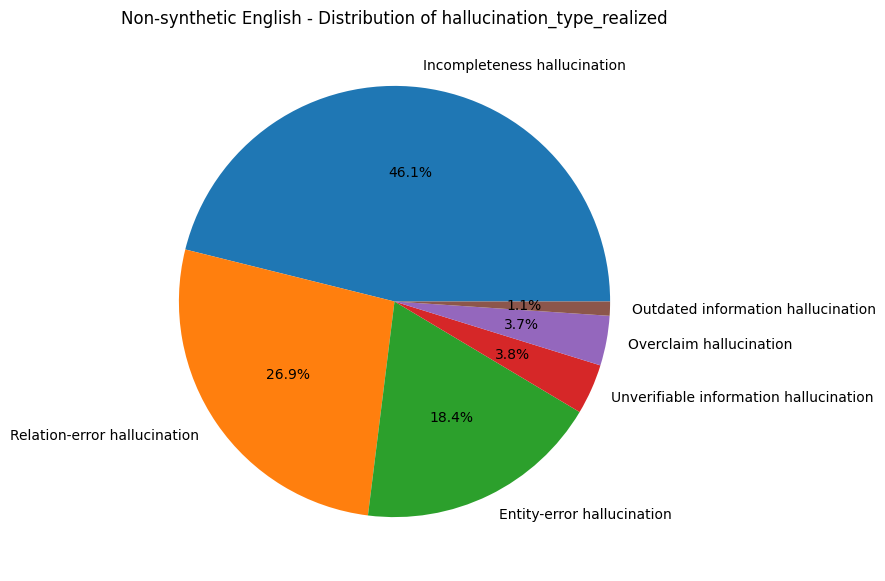

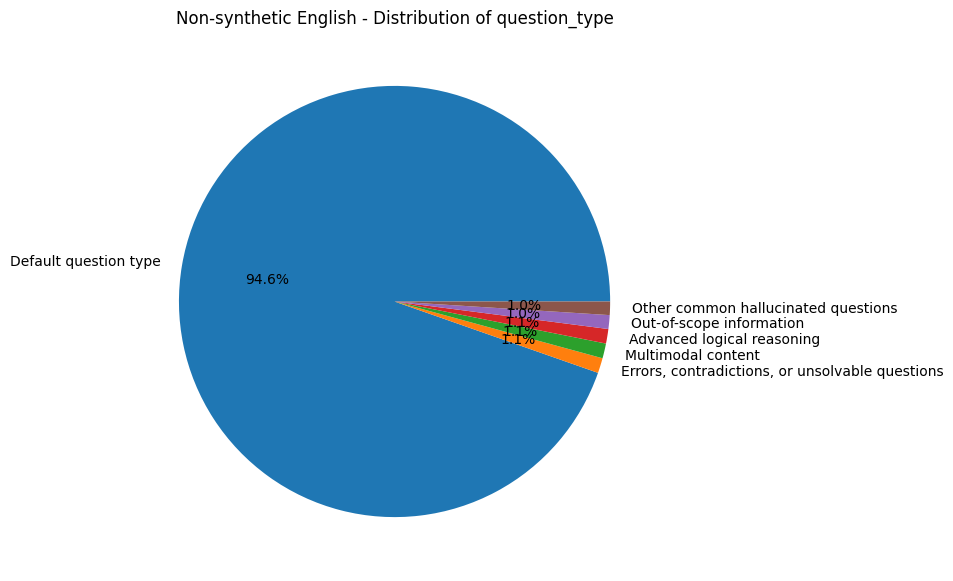

In [13]:
import matplotlib.pyplot as plt

# List of datasets and columns to analyze
datasets = {
    'all_datasets.csv': 'All Combined',
    'synthetic_only.csv': 'Synthetic Only', 
    'non_synthetic_only.csv': 'Non-synthetic Only',
    'english_only.csv': 'English Only',
    'synthetic_english.csv': 'Synthetic English',
    'non_synthetic_english.csv': 'Non-synthetic English'
}

columns = [
    'label',
    'rag_model', 
    'language',
    'synthetic',
    'hallucination_type_realized',
    'question_type',
]

# Create pie charts for each dataset and column
for dataset_file, dataset_name in datasets.items():
    try:
        df = pd.read_csv(f'temp/{dataset_file}')
        
        for col in columns:
            if col in df.columns:
                # Count values and remove NaN
                value_counts = df[col].value_counts().dropna()
                
                if not value_counts.empty:
                    plt.figure(figsize=(15, 7))
                    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
                    plt.title(f'{dataset_name} - Distribution of {col}')
                    plt.show()
            else:
                print(f"Column {col} not found in {dataset_file}")
                
    except Exception as e:
        print(f"Error processing {dataset_file}: {e}")


# Human Label Analysis

In [1]:
import os
import pandas as pd

# Initialize empty list to store dataframes
dfs = []

# Loop through all CSV files in the directory
for filename in os.listdir('combined_datasets_for_evals'):
    if filename.endswith('.csv'):
        try:
            # Read the CSV file
            df = pd.read_csv(f'combined_datasets_for_evals/{filename}')
            
            # Filter rows that have a human_label value (not null)
            if 'human_label' in df.columns:
                df_with_labels = df[df['human_label'].notna()]
                if not df_with_labels.empty:
                    dfs.append(df_with_labels)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Combine all dataframes
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
else:
    print("No data found with human labels")


/var/folders/z6/6g1hmm4x2dl0z84s6bwkgdzr0000gn/T/ipykernel_49934/2644237147.py:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'combined_datasets_for_evals/{filename}')
/var/folders/z6/6g1hmm4x2dl0z84s6bwkgdzr0000gn/T/ipykernel_49934/2644237147.py:12: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'combined_datasets_for_evals/{filename}')


Combined dataset shape: (15024, 22)


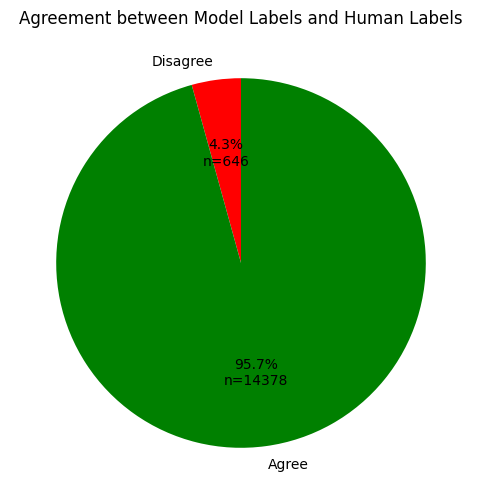

In [8]:
import matplotlib.pyplot as plt

# Create a comparison of label and human_label
agreement_counts = (combined_df['label'] == combined_df['human_label']).value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie([agreement_counts[False], agreement_counts[True]], 
        labels=['Disagree', 'Agree'],
        colors=['red', 'green'],
        autopct=lambda pct: f'{pct:.1f}%\nn={int(pct/100.*sum(agreement_counts))}',
        startangle=90)
plt.title('Agreement between Model Labels and Human Labels')
plt.show()


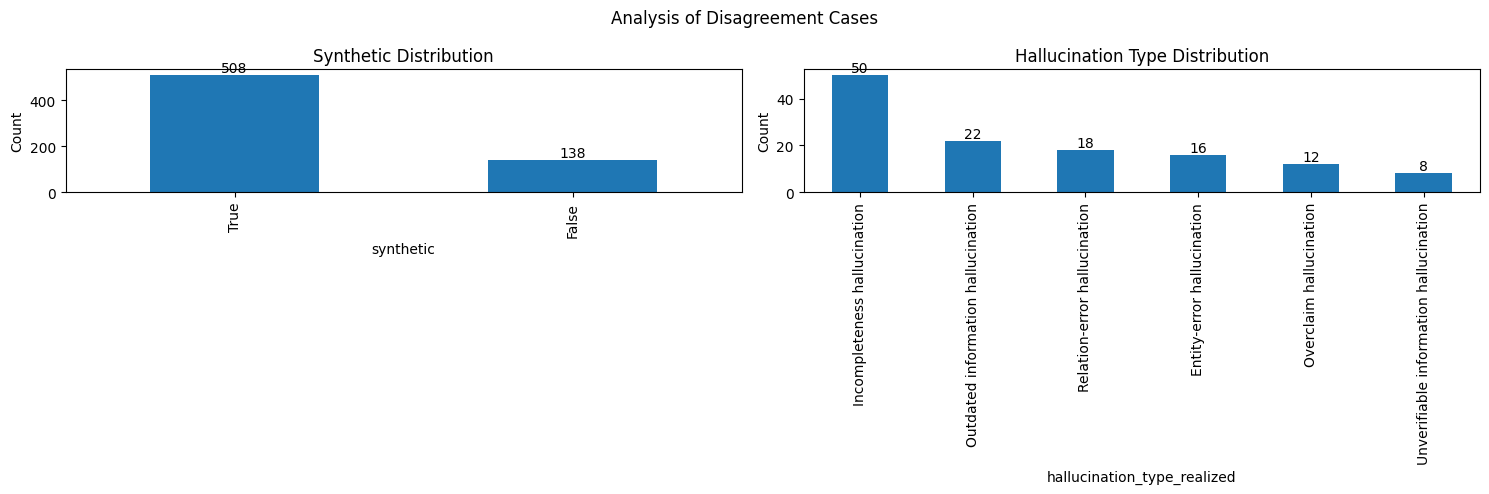

In [11]:
# Filter for disagreements
disagreements_df = combined_df[combined_df['label'] != combined_df['human_label']]

# Create subplots for each column we want to analyze
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Analysis of Disagreement Cases')

# Plot synthetic distribution
disagreements_df['synthetic'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Synthetic Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(disagreements_df['synthetic'].value_counts()):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Plot hallucination_type_realized distribution
disagreements_df['hallucination_type_realized'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Hallucination Type Distribution')
axes[1].set_ylabel('Count')
for i, v in enumerate(disagreements_df['hallucination_type_realized'].value_counts()):
    axes[1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


/var/folders/z6/6g1hmm4x2dl0z84s6bwkgdzr0000gn/T/ipykernel_49934/3789402251.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_datasets_for_evals/synthetic_hallucinations_english.csv')


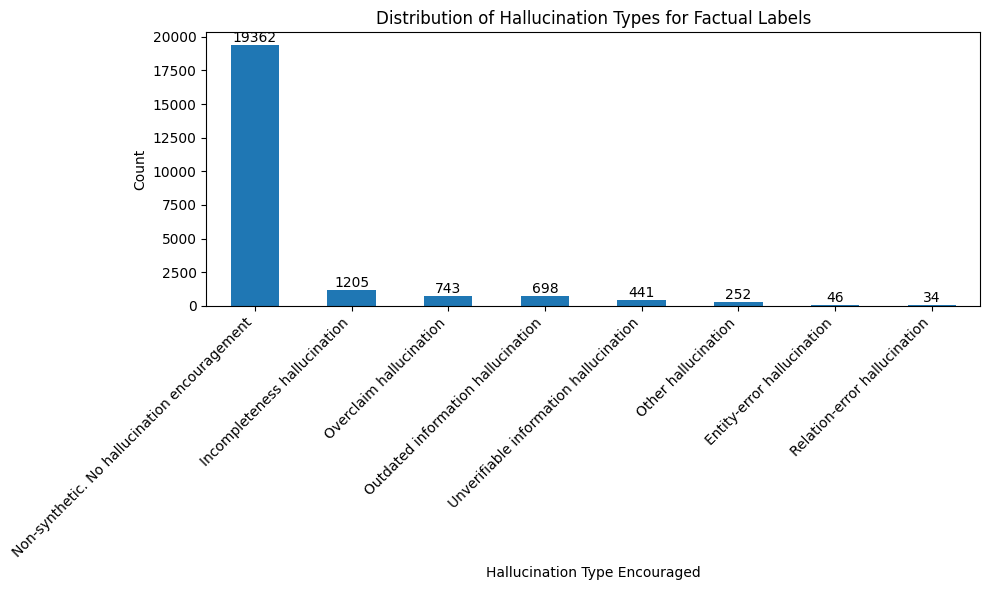


Counts of hallucination types for factual labels:
hallucination_type_encouraged
Non-synthetic. No hallucination encouragement    19362
Incompleteness hallucination                      1205
Overclaim hallucination                            743
Outdated information hallucination                 698
Unverifiable information hallucination             441
Other hallucination                                252
Entity-error hallucination                          46
Relation-error hallucination                        34
Name: count, dtype: int64


In [7]:
# Read the dataset
df = pd.read_csv('combined_datasets_for_evals/synthetic_hallucinations_english.csv')

# Get counts where label is factual, grouped by hallucination_type_encouraged
factual_counts = df[df['label'] == 'factual']['hallucination_type_encouraged'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
factual_counts.plot(kind='bar')
plt.title('Distribution of Hallucination Types for Factual Labels')
plt.xlabel('Hallucination Type Encouraged')
plt.ylabel('Count')

# Add value labels on top of bars
for i, v in enumerate(factual_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the counts
print("\nCounts of hallucination types for factual labels:")
print(factual_counts)
